# Import packages and data 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')
import warnings
warnings.filterwarnings('ignore')

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.1 scipy==1.4.1 pandas==1.0.5 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


# Load FBM raw dataset

In [4]:
adata = sc.read("/Users/b8058304/Documents/PhD_work/Coding/downs_bm/data/downs_raw_dr_20200714.h5ad")

In [5]:
from scipy.sparse import csr_matrix
adata.X = sparse.csr_matrix(adata.X)

In [6]:
adata.raw = adata

In [7]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CAR                          4
CD8 T cell                  55
CD14 monocyte              252
CD56 bright NK              36
CMP                         37
DC1                         16
DC2                         94
DC3                         98
HSC                         45
ILC precursor               13
MEMP                        42
MK                          25
MOP                        350
MSC                         18
Treg                         8
chondrocyte                  4
early B cell                23
early MK                     7
early erythroid            766
endothelium                 37
eo/baso/mast precursor      40
eosinophil                  41
late erythroid            3341
macrophage                  64
mast cell                   27
mature B cell               20
mature NK                   69
mid erythroid             2082
myelocyte                  218
neutrophil                 245
osteoblast                  11
osteoclast                 

In [8]:
adata.obs

,lanes,mad_prd,auto_prd,cell.labels,orig.ident,sequencing.type,age,percent.mito,cell.labels_20200713
index,,,,,,,,,
AAACCTGAGTACGTTC-1-DSOX4,DSOX4,False,False,early erythroid,ICH12740,5GEX,13PCW,0.048956,early erythroid
AAACCTGCAAGCGATG-1-DSOX4,DSOX4,False,False,late erythroid,ICH12740,5GEX,13PCW,0.023771,late erythroid
AAACGGGCACCGAAAG-1-DSOX4,DSOX4,False,False,promonocyte,ICH12740,5GEX,13PCW,0.058779,monocyte precursor
AAACGGGGTTATGCGT-1-DSOX4,DSOX4,False,False,late erythroid,ICH12740,5GEX,13PCW,0.011670,late erythroid
AAAGATGGTAGCACGA-1-DSOX4,DSOX4,False,False,pre B cell,ICH12740,5GEX,13PCW,0.044516,pre B cell
...,...,...,...,...,...,...,...,...,...
TTTGTCAGTCCAAGTT-1-DSOX19_2,DSOX19_2,False,False,late erythroid,ICH14486,5GEX,12PCW,0.022784,late erythroid
TTTGTCAGTCCTGCTT-1-DSOX19_2,DSOX19_2,False,False,promonocyte,ICH14486,5GEX,12PCW,0.039085,monocyte precursor
TTTGTCAGTTAAGTAG-1-DSOX19_2,DSOX19_2,False,False,late erythroid,ICH14486,5GEX,12PCW,0.022529,late erythroid


In [9]:
adata.obs["orig.ident"] = adata.obs["orig.ident"].replace(["ICH12740", "ICH12813", "ICH12941", "ICH14486"],
                                                          ["D1", "D2", "D3", "D4"])
cell_numbers = adata.obs.groupby(["orig.ident"]).apply(len)
cell_numbers

orig.ident
D1    1613
D2    1643
D3     496
D4    4870
dtype: int64

# Add QC

In [10]:
# add the total counts per cell as observations-annotation to adata
adata.obs['nUMI'] = adata.X.sum(axis=1)
sc.pp.calculate_qc_metrics(adata, var_type='genes', layer=None, use_raw=False, inplace=True, parallel=None)
adata.obs["nGene"] = adata.obs["n_genes_by_counts"]

del adata.obs["n_genes_by_counts"]
del adata.obs["log1p_n_genes_by_counts"]
del adata.obs["log1p_total_counts"]
del adata.obs["total_counts"]
del adata.obs["pct_counts_in_top_50_genes"]
del adata.obs["pct_counts_in_top_100_genes"]
del adata.obs["pct_counts_in_top_200_genes"]
del adata.obs["pct_counts_in_top_500_genes"]
del adata.var["n_cells_by_counts"]
del adata.var["mean_counts"]
del adata.var["log1p_mean_counts"]
del adata.var["pct_dropout_by_counts"]
del adata.var["total_counts"]
del adata.var["log1p_total_counts"]

In [11]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent.mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1

... storing 'orig.ident' as categorical


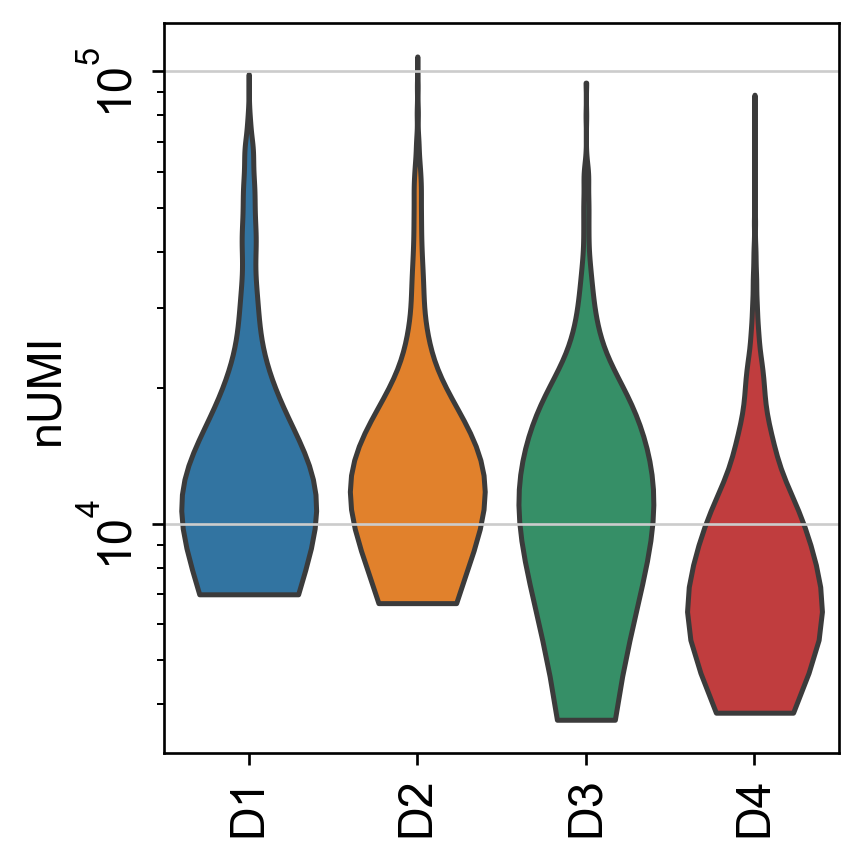

In [12]:
# Quality control - plot QC metrics
#Sample quality plots
sc.pl.violin(adata, 'nUMI', groupby='orig.ident', size=1, log=True, cut=0, stripplot=False, rotation=90, 
                 save="FBM_downs_numi_violin_20200619.pdf")

In [13]:
sc.pl.violin(adata, 'percent.mito', groupby='orig.ident', log=False, cut=0, stripplot=False, rotation=90, 
            save="FBM_downs_pmito_violin_20200619.pdf", show=False)